(assign8:solution_heights)=
# Assignment 8 solution


- upload a notebook that
  -  overlays your radar cases's ground track on the nearest GOES cloud height image using the code in {ref}`week12:goes_earthcare`
  - Add a function that locates image row/column values along the radar lat/lon coordinates
    of the GOES height image. Use it to produce a height/distance plot that shows the
    radar reflectivity image  with the colocated GOES HT heights overlaid as a line on the image.  Do
    GOES and earthcare agree on the location of cloudtop?

## Installation

- fetch and rebase to pick up the week13 folder with this ipynb file
- I modified the end of the {ref}`week12:goes_earthcare` notebook
  to produce a new file called [clipped_goes.tif](https://drive.google.com/drive/folders/1tZQ9fG8C32fOR5NR-dsLvR0iT6SOUegn?usp=sharing) which needs to be copied to `~/repos/a301/satdata/earthcare`.  In that file I also included the cartopy CRS so I could make a map of the GOES heights to show how to debug the satellite track.

## Workflow

1) Get the radar groundtrack
2) Read the GOES heights from `clipped_goes.tif`
3) Find the row, column on the image for every radar lat,lon point
4) Plot the radar reflectivity and add the GOES height lin for each of those points

## Debugging

In the last section I show how to plot the radar groundtrack on the satellie image, by setting the row, column pixels along the groundtrack to a high value show they show up.

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pyproj
from matplotlib import pyplot as plt
import datetime
import pytz
import pandas as pd
from pyproj import CRS, Transformer
import affine
from a301_extras.sat_lib import make_new_rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray
import xarray as xr

running __init__.py


In [2]:
data_dir = Path().home() / 'repos/a301/satdata/earthcare'
radar_filepath = list(data_dir.glob("**/*.nc"))[0]
radar_ds = xr.open_dataset(radar_filepath)
casenum = radar_ds.attrs['casenum']
radar_ds

<xarray.Dataset> Size: 21MB
Dimensions:     (height: 218, distance: 8021)
Coordinates:
  * height      (height) float64 2kB 2.019e+04 2.009e+04 ... -1.494e+03
  * distance    (distance) float64 64kB 0.0 0.5027 1.006 ... 4.172e+03 4.172e+03
Data variables:
    dbZ         (height, distance) float32 7MB ...
    velocity    (height, distance) float32 7MB ...
    binHeights  (height, distance) float32 7MB ...
    longitude   (distance) float64 64kB ...
    latitude    (distance) float64 64kB ...
    time        (distance) datetime64[ns] 64kB ...
Attributes:
    history:   written by ec_to_xarray on 2025-03-29 09:50:41.584666
    timezone:  UTC
    casenum:   case4

### Get the radar ground track

In [3]:
latvec = radar_ds.latitude
lonvec = radar_ds.longitude

## open clipped ht file

In [4]:
ht_filepath = list(data_dir.glob("**/*.tif"))[0]
ht_filepath

PosixPath('/Users/phil/repos/a301/satdata/earthcare/clipped_goes.tif')

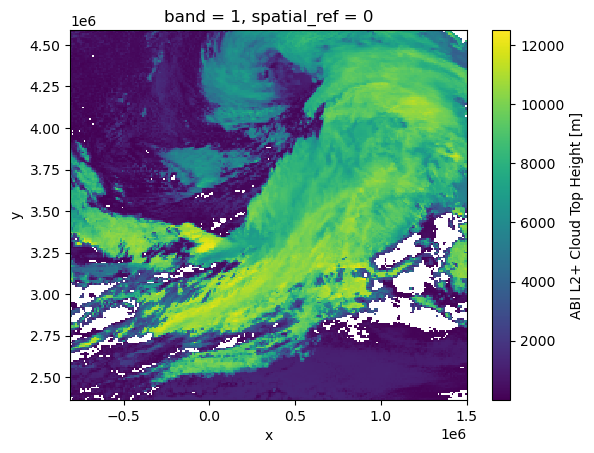

In [5]:
goes_ht = rioxarray.open_rasterio(ht_filepath).squeeze()
goes_ht.plot.imshow();

## get row,column from lat,lon

### Function get_rowcol

reuse code from {ref}`(week12:goes_earthcare` and {ref}`week12:goes_temperature`

In [6]:
affine_transform = goes_ht.rio.transform()
goes_crs = goes_ht.rio.crs
latlon_crs = pyproj.CRS.from_epsg(4326)
goes_latlon_xy = Transformer.from_crs(latlon_crs, goes_crs,always_xy=True)
x_goes,y_goes = goes_latlon_xy.transform(lonvec,latvec)

In [7]:
def get_rowcol(affine_transform,x_coords,y_coords):
    image_row, image_col = ~affine_transform * (x_coords,y_coords)
    image_col = np.round(image_col).astype(np.int32)
    image_row = np.round(image_row).astype(np.int32)
    return image_col,image_row

In [8]:
track_col, track_row = get_rowcol(affine_transform,x_goes,y_goes)

## Sample GOES heights along track

In [9]:
the_heights = []
for row, col in zip(track_col, track_row):
    the_heights.append(goes_ht[row,col].data)

## Add to the radar reflectivity plot

Not sure why GOES doesn't see the cloud at 600 km, but overall good agreement.  Notice that the GOES estimates are about 200 meters below the radar cloud top.

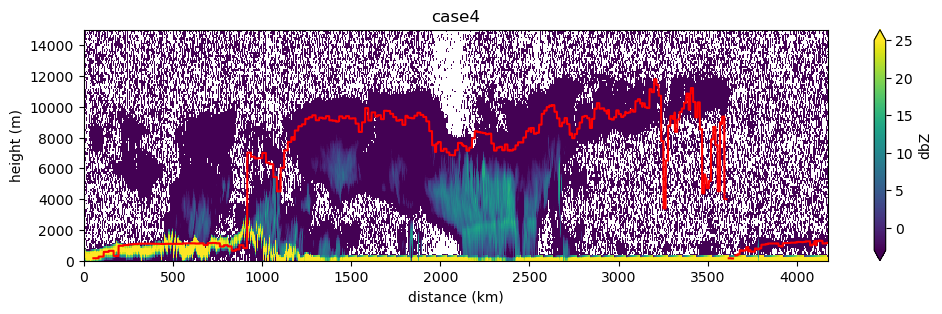

In [10]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['dbZ'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=25);
ax.plot(radar_ds['distance'],the_heights,'r-')
ax.set_ylim(0,15000)
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(f"{casenum}");

## To debug: check against image

If GOES and the radar are not close to each other, then it might help to
see the radar track on the GOES image.  To do that, use `imshow` to 
show the heights, but modified the pixel values along the groundtrack
so the are clear in the image.

### Make groundtrack heights stand out

Set all the pixels along the ground track to 20000 m.

In [11]:
for row, col in zip(track_col, track_row):
    goes_ht[row,col]=20000

### Plot the modified image

In [12]:
xmin = -145 #longitude degrees east
xmax = -85.
ymax = 70  #latitude degrees north
ymin = 20
xmin_goes,ymin_goes = goes_latlon_xy.transform(xmin,ymin)
xmax_goes,ymax_goes = goes_latlon_xy.transform(xmax,ymax)
extent = (xmin_goes,xmax_goes,ymin_goes,ymax_goes)

In [13]:
def make_cartopy_crs(wkt_string):
    """
    Hack to solve cartopy bug which prevents it from using
    pyproj CRS objects directly.  I create the pyproj crs then
    take it apart as a dictionary and put it back together
    as a cartopy crs
    """
    bad_cartopy_crs = ccrs.Projection(wkt_string)
    terms=bad_cartopy_crs.to_dict()
    globe_kwargs = dict(semimajor_axis = terms['a'],
                  semiminor_axis=6356752.3141,
                 inverse_flattening = terms['rf'])
    crs_kwargs = dict(central_longitude = terms['lon_0'],
                    satellite_height = terms['h'],
                 sweep_axis = 'x')
    globe=ccrs.Globe(ellipse=None, **globe_kwargs)
    cartopy_crs = ccrs.Geostationary(**crs_kwargs,globe=globe)
    return cartopy_crs

### Use the CRS I wrote out in the tif file

/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


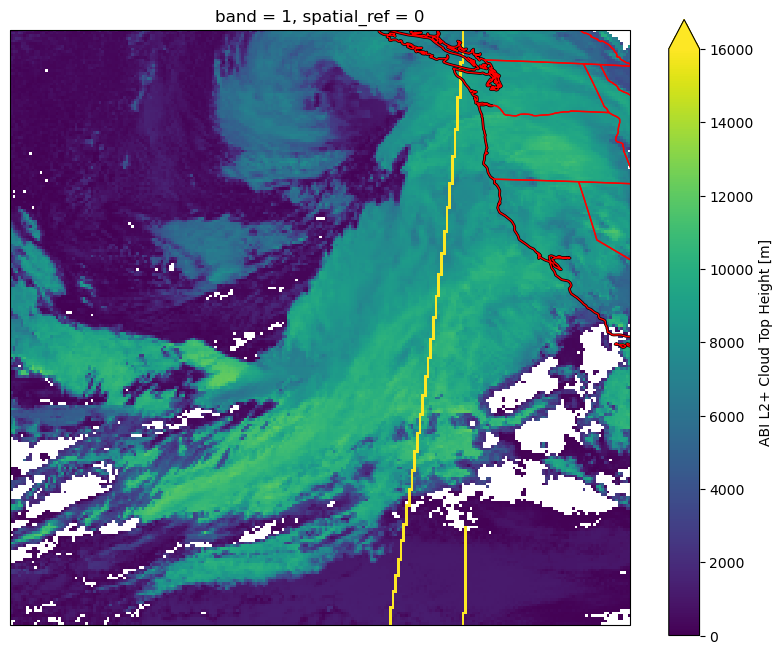

In [14]:
wkt_string = goes_ht.attrs['cartopy_crs']
extent = (xmin_goes,xmax_goes,ymin_goes,ymax_goes)
cartopy_crs = make_cartopy_crs(wkt_string)
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':cartopy_crs})
goes_ht.plot.imshow(
    ax = ax,
    origin="upper",
    extent= extent,
    transform=cartopy_crs,
    interpolation="nearest",
    vmin=0,
    vmax=16000
);
ax.coastlines(resolution="50m", color="black", linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES,edgecolor="red")